<a href="https://colab.research.google.com/github/aws3ma/computer_vision/blob/main/IRIS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
%cd /gdrive/MyDrive/computer_vision/grayscale_images/train/

/gdrive/MyDrive/computer_vision/grayscale_images/train


In [ ]:
image = cv2.imread('./5/left/chongpkl2.bmp',cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('./14/left/liujwl5.bmp',cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('./22/right/mimir5.bmp',cv2.IMREAD_GRAYSCALE)

In [ ]:
def show_images(images:list):
  n = len(images)
  fig, axes = plt.subplots(1, n, figsize=(8, 4))
  for i in range(n):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title('Original '+str(i))
    axes[i].axis('off')
  plt.show()

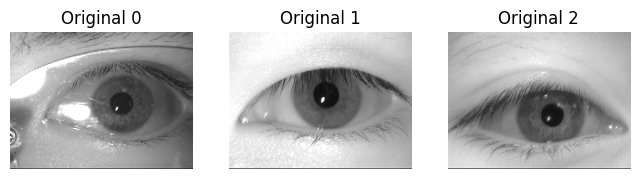

In [ ]:
show_images([image,image2,image3])

In [ ]:
import numpy as np
from skimage import io, feature

def canny_segmentation(gray_image, sigma=1.0, low_threshold=0.1, high_threshold=0.2):

    # Apply the Canny edge detection algorithm
    edges = feature.canny(gray_image, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

    # Afficher l'image des contours
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

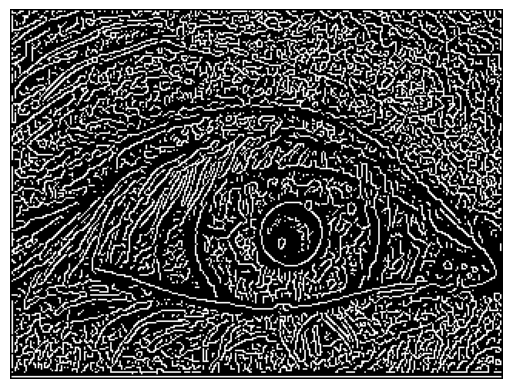

In [ ]:
canny_segmentation(image3)

In [ ]:
def extract_iris_from_eye(gray_eye, sigma=2, hough_radii_range=(50, 100)):
    from skimage import io, feature, transform
    import numpy as np
    from skimage.draw import disk
    # Apply Canny edge detection
    edges = feature.canny(gray_eye, sigma=sigma)

    # Find the iris region using circular Hough transform
    hough_radii = np.arange(*hough_radii_range)
    hough_res = transform.hough_circle(edges, hough_radii)
    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

    # Get the coordinates of the circle
    circle_y, circle_x, circle_radius = cy[0], cx[0], radii[0]

    # Create a circular mask for the iris
    iris_mask = np.zeros_like(gray_eye, dtype=np.uint8)
    iris_rr, iris_cc = disk((circle_y, circle_x), circle_radius)
    iris_mask[iris_rr, iris_cc] = 1

    # Find the pupil region using circular Hough transform
    pupil_radii = np.arange(10, 30)  # Adjust radii range as needed
    pupil_res = transform.hough_circle(edges, pupil_radii)
    pupil_accums, pupil_cx, pupil_cy, pupil_radii = transform.hough_circle_peaks(pupil_res, pupil_radii, total_num_peaks=1)

    # Get the coordinates of the pupil circle
    pupil_circle_y, pupil_circle_x = pupil_cy[0], pupil_cx[0]
    pupil_circle_radius = pupil_radii[0]

    # Create a circular mask for the pupil
    pupil_mask = np.ones_like(gray_eye, dtype=np.uint8)
    pupil_rr, pupil_cc = disk((pupil_circle_y, pupil_circle_x), pupil_circle_radius)
    pupil_mask[pupil_rr, pupil_cc] = 0

    # Apply the circular masks to crop the iris and pupil regions
    iris_region = gray_eye * iris_mask
    iris_only_region = iris_region * pupil_mask

    return iris_only_region


In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(extract_iris_from_eye(image3), cmap='gray')
#plt.title("Cropped Iris Region (Without Pupil)")
plt.axis('off')
plt.show()

NameError: ignored

<Figure size 600x600 with 0 Axes>

In [ ]:
%cd ..

/gdrive/MyDrive/computer_vision/grayscale_images


In [ ]:
%ls

test/  train/  train_iris/  train_iris_normalized/


In [ ]:
input_folder = 'train/'
output_folder = 'train_iris/'
# List all files in the input directory
classes = os.listdir(input_folder)

In [ ]:
# Process each image in the input folder
for classe in classes:
  right = os.listdir(os.path.join(input_folder,classe,'right'))
  for image_file in right:
      # Check if the file is an image (you may want to refine this check)
      if image_file.endswith(('.jpg', '.png', '.jpeg', '.bmp')):
          # Read the image from the input directory
          input_path = os.path.join(input_folder, classe,'right',image_file)
          image = cv2.imread(input_path,cv2.IMREAD_GRAYSCALE)
          # Convert the image to grayscale
          iris_image = extract_iris_from_eye(image)
          os.makedirs(os.path.join(output_folder, classe,'right'), exist_ok=True)
          # Create the output file path
          output_path = os.path.join(output_folder, classe,'right',image_file)
          # Save the grayscale image to the output directory
          cv2.imwrite(output_path, iris_image)

  left = os.listdir(os.path.join(input_folder,classe,'left'))
  for image_file in left:
      # Check if the file is an image (you may want to refine this check)
      if image_file.endswith(('.jpg', '.png', '.jpeg', '.bmp')):
          # Read the image from the input directory
          input_path = os.path.join(input_folder, classe,'left',image_file)
          image = cv2.imread(input_path,cv2.IMREAD_GRAYSCALE)

          # Convert the image to grayscale
          iris_image = extract_iris_from_eye(image)

          # Create the output file path
          os.makedirs(os.path.join(output_folder, classe,'left'), exist_ok=True)
          output_path = os.path.join(output_folder, classe,'left',image_file)

          # Save the grayscale image to the output directory
          cv2.imwrite(output_path, iris_image)
print("Conversion and saving complete.")

In [ ]:
def daugman_normalization(image, height, width, r_in, r_out):
    import numpy as np
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    return flat  # liang

In [ ]:
%cd train_iris/

/gdrive/MyDrive/computer_vision/grayscale_images/train_iris


In [ ]:
image = cv2.imread('./5/left/chongpkl2.bmp',cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('./14/left/liujwl5.bmp',cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('./22/right/mimir5.bmp',cv2.IMREAD_GRAYSCALE)

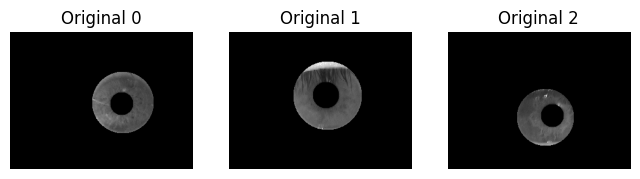

In [ ]:
show_images([image,image2,image3])

In [ ]:
daugman_normalized_iris = daugman_normalization(image, *(240, 320, 10, 50))

In [ ]:
daugman_normalized_iris2 = daugman_normalization(image2, *(240, 320, 10, 50))

In [ ]:
daugman_normalized_iris3 = daugman_normalization(image3, *(240, 320, 10, 50))

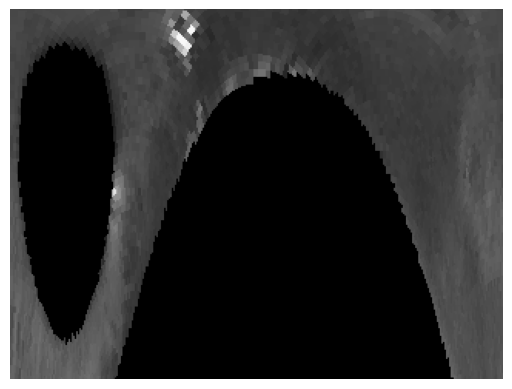

In [ ]:
plt.figure()
plt.imshow(daugman_normalized_iris3, cmap='gray')
#plt.title("Cropped Iris Region (Without Pupil)")
plt.axis('off')
plt.show()

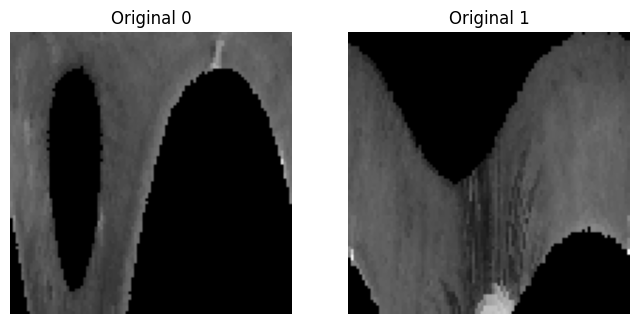

In [ ]:
show_images([daugman_normalized_iris,daugman_normalized_iris2])

In [ ]:
%cd ..

/gdrive/MyDrive/computer_vision/grayscale_images


In [ ]:
%ls

test/  train/  train_iris/  train_iris_normalized/


In [ ]:
input_folder = 'train/'
output_folder = 'train_iris_normalized/'
# List all files in the input directory
classes = os.listdir(input_folder)

In [ ]:
# Process each image in the input folder
for classe in classes:
  right = os.listdir(os.path.join(input_folder,classe,'right'))
  for image_file in right:
      # Check if the file is an image (you may want to refine this check)
      if image_file.endswith(('.jpg', '.png', '.jpeg', '.bmp')):
          # Read the image from the input directory
          input_path = os.path.join(input_folder, classe,'right',image_file)
          image = cv2.imread(input_path,cv2.IMREAD_GRAYSCALE)
          # Convert the image to grayscale
          iris_image = daugman_normalization(image, *(240, 320, 10, 50))
          os.makedirs(os.path.join(output_folder, classe,'right'), exist_ok=True)
          # Create the output file path
          output_path = os.path.join(output_folder, classe,'right',image_file)
          # Save the grayscale image to the output directory
          cv2.imwrite(output_path, iris_image)

  left = os.listdir(os.path.join(input_folder,classe,'left'))
  for image_file in left:
      # Check if the file is an image (you may want to refine this check)
      if image_file.endswith(('.jpg', '.png', '.jpeg', '.bmp')):
          # Read the image from the input directory
          input_path = os.path.join(input_folder, classe,'left',image_file)
          image = cv2.imread(input_path,cv2.IMREAD_GRAYSCALE)

          # Convert the image to grayscale
          iris_image = daugman_normalization(image, *(240, 320, 10, 50))

          # Create the output file path
          os.makedirs(os.path.join(output_folder, classe,'left'), exist_ok=True)
          output_path = os.path.join(output_folder, classe,'left',image_file)

          # Save the grayscale image to the output directory
          cv2.imwrite(output_path, iris_image)
print("Conversion and saving complete.")

Conversion and saving complete.


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
%ls

test/  train/  train_iris/  train_iris_normalized/


In [ ]:
# Path to the directory containing the training images
train_directory = "train_iris_normalized"
test_directory = "test"

In [ ]:
def load_images(path:str):
  classes = os.listdir(path)
  images = []
  labels = []
  for classe in classes:
    right = os.listdir(os.path.join(path,classe,'right'))
    for image_file in right:
        # Check if the file is an image (you may want to refine this check)
            # Read the image from the input directory
            input_path = os.path.join(path, classe,'right',image_file)
            image = cv2.imread(input_path,cv2.IMREAD_GRAYSCALE)
            # Convert the image to grayscale
            images.append(image.flatten())
            labels.append(classe)


    left = os.listdir(os.path.join(path,classe,'left'))
    for image_file in left:
        # Check if the file is an image (you may want to refine this check)
            # Read the image from the input directory
            input_path = os.path.join(path, classe,'left',image_file)
            image = cv2.imread(input_path,cv2.IMREAD_GRAYSCALE)
            images.append(image.flatten())
            labels.append(classe)
  return (images,labels)

In [ ]:
train_images, train_labels=load_images(train_directory)

In [ ]:
test_images, test_labels = load_images(test_directory)

In [ ]:
len(test_images)==len(test_labels)

True

In [ ]:
len(train_labels)==len(train_images)

True

In [ ]:
import numpy as np
# Convert lists to numpy arrays for training data
X_train = np.array(train_images)
y_train = np.array(train_labels)

# Convert lists to numpy arrays for testing data
X_test = np.array(test_images)
y_test = np.array(test_labels)

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.022222222222222223


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.016666666666666666

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(240, 320),  # Adjust the target size as needed
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',  # Assuming you have multiple classes
)

Found 270 images belonging to 45 classes.


In [ ]:
test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(240, 320),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
)

Found 180 images belonging to 45 classes.


In [ ]:
# Create a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240,320, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10)  # Adjust the number of epochs as needed


Epoch 1/10
9/9 [==============================] - 32s 4s/step - loss: 4.6331 - accuracy: 0.0111
Epoch 2/10
9/9 [==============================] - 32s 4s/step - loss: 3.8111 - accuracy: 0.0148
Epoch 3/10
9/9 [==============================] - 29s 3s/step - loss: 3.7637 - accuracy: 0.0667
Epoch 4/10
9/9 [==============================] - 32s 4s/step - loss: 3.6168 - accuracy: 0.1222
Epoch 5/10
9/9 [==============================] - 30s 4s/step - loss: 3.0794 - accuracy: 0.2111
Epoch 6/10
9/9 [==============================] - 36s 4s/step - loss: 2.0736 - accuracy: 0.5481
Epoch 7/10
9/9 [==============================] - 32s 4s/step - loss: 0.9279 - accuracy: 0.8481
Epoch 8/10
9/9 [==============================] - 32s 3s/step - loss: 0.2465 - accuracy: 0.9815
Epoch 9/10
9/9 [==============================] - 33s 4s/step - loss: 0.0501 - accuracy: 1.0000
Epoch 10/10
9/9 [==============================] - 32s 4s/step - loss: 0.0130 - accuracy: 1.0000


In [ ]:
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()

553467096/553467096 [==============================] - 8s 0us/step


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_ohe = model.predict(test_generator)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)



In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape=(12, 12)

ValueError: ignored

In [ ]:
y_pred_labels.shape

(180,)

In [ ]:
y_test.shape

(270,)